# Time Series Analysis of US CO2 Levels

### Import Libraries

In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

### Plot The Time Series

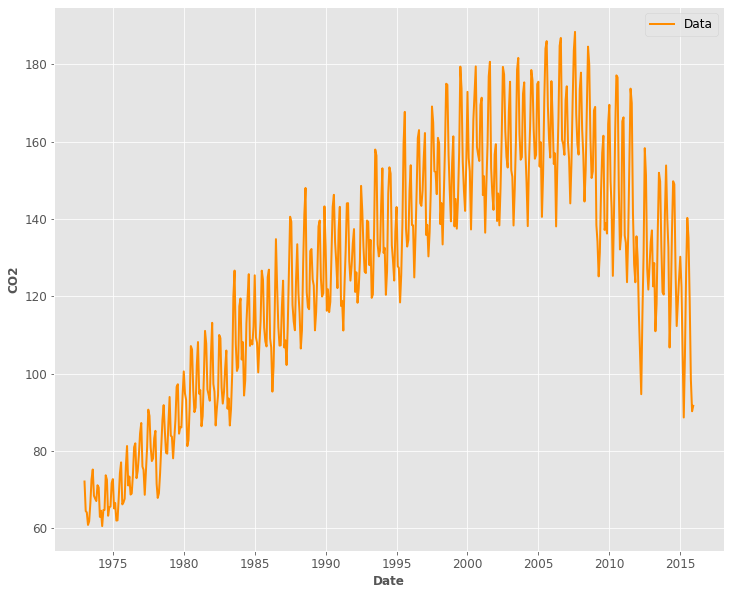

In [2]:
data = pd.read_csv('co2.csv')
data = data[:-7]
year_month=np.array(data['YYYYMM']).astype('str')
year = []
month = []
date = []
for ym in year_month:
    year.append(int(ym[:-2]))
    month.append(int(ym[-2::]))
    date.append(ym[:-2]+'-'+ym[-2::])
data['year'] = year 
data['month'] = month
data['date']=date
data['date']=pd.to_datetime(data['date'], format='%Y-%m')
plt.plot(data.date,data.Value,label='Data',color='darkorange')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.legend()

### General Trend

In [3]:
X = np.array(data.index.tolist())
y = np.array(data.Value)
model = np.poly1d(np.polyfit(X, y, 4))

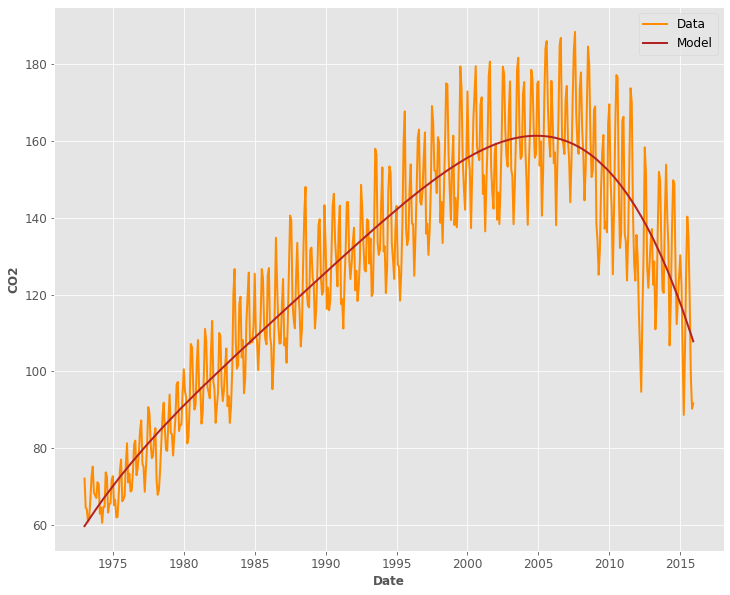

In [4]:
plt.plot(data.date,data.Value,label='Data',color='darkorange')
plt.plot(data.date,model(X),label='Model',color='firebrick')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.legend()

### Recurrent Patterns

In [5]:
data['detrend_data']=np.array(data.Value-model(X))

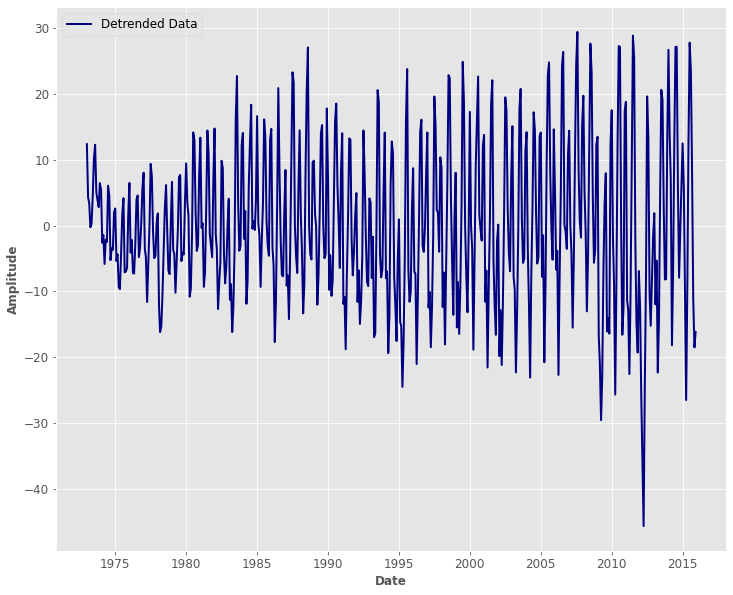

In [6]:
plt.plot(data.date,data['detrend_data'],color='navy',label='Detrended Data')
plt.xlabel('Date')
plt.ylabel('Amplitude')
plt.legend()

### Fourier Transformation for Months

In [7]:
y =np.array(data['detrend_data']).reshape(1,-1)[0]

([<matplotlib.axis.XTick at 0x7fe0f96ae220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

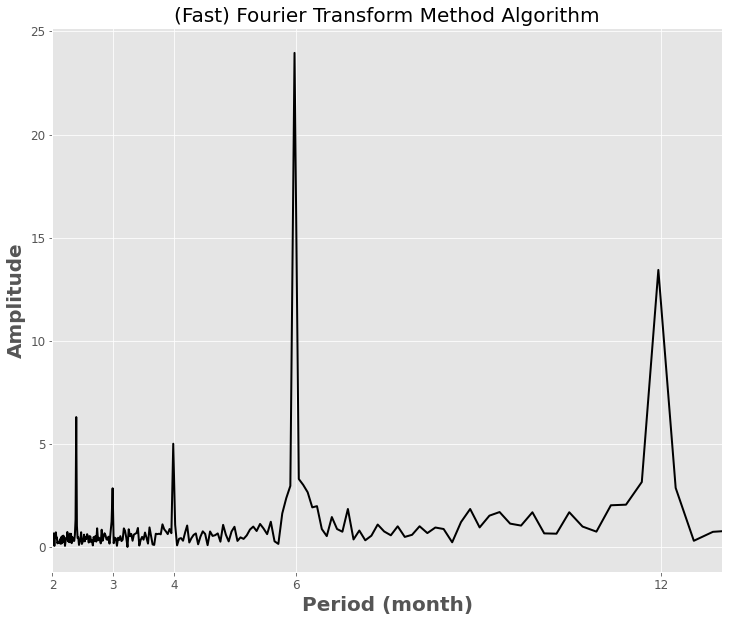

In [520]:
FFT =np.fft.fft(y)
new_N=int(len(FFT)/2) 
f_nat=1
new_X = np.linspace(10**-12, f_nat/2, new_N, endpoint=True)
new_Xph=1.0/(new_X)
FFT_abs=np.abs(FFT)
plt.plot(new_Xph,2*FFT_abs[0:int(len(FFT)/2.)]/len(new_Xph),color='black')
plt.xlabel('Period (month)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=20)
plt.grid(True)
plt.xlim(2,13)
plt.xticks([2,3,4,6,12])

### Predicted Time Series with Gaussian Regressor

In [512]:
train_data = data.loc[np.linspace(0,len(data)-1,int(len(data)*0.60)).astype(int)]

In [514]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
kernel = 1.0 * RBF(length_scale_bounds=(1, 100)) + WhiteKernel()
X = np.array(train_data.index.tolist()).reshape(-1,1)
y =np.array(train_data['detrend_data']).reshape(-1,1)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y)
X = np.array(data.index.tolist()).reshape(-1,1)
y =np.array(data['detrend_data']).reshape(-1,1)
pred_mean,pred_std = gpr.predict(X, return_std=True)

In [515]:
pred_mean = pred_mean.ravel()

In [516]:
X = X.ravel()

Text(0, 0.5, 'Amplitude')

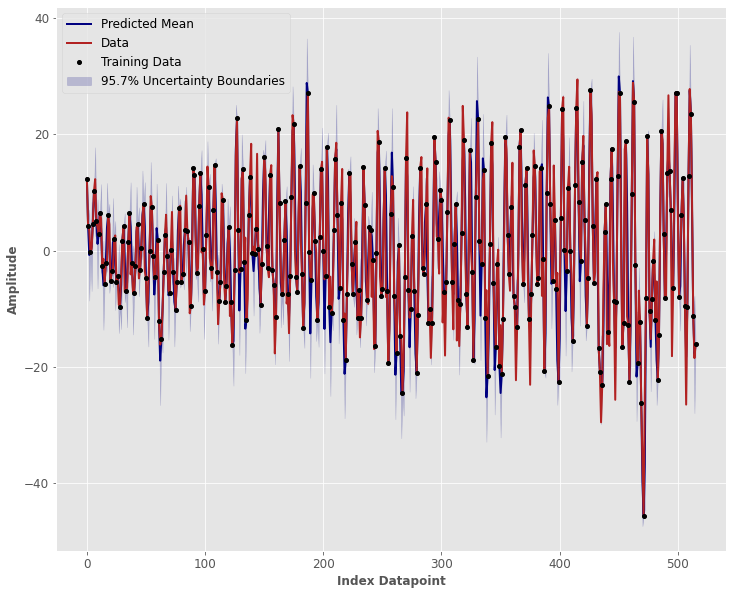

In [517]:
plt.plot(X,pred_mean,color='navy',label='Predicted Mean')
plt.fill_between(X,pred_mean-1.96*pred_std,pred_mean+1.96*pred_std,color='navy',alpha=0.2,label='95.7% Uncertainty Boundaries')
plt.plot(X,y,color='firebrick',label='Data')
X = np.array(train_data.index.tolist()).reshape(-1,1)
y =np.array(train_data['detrend_data']).reshape(-1,1)
plt.plot(X,y,'.',label='Training Data',color='k')
plt.legend()
plt.xlabel('Index Datapoint')
plt.ylabel('Amplitude')

(0.0, 200.0)

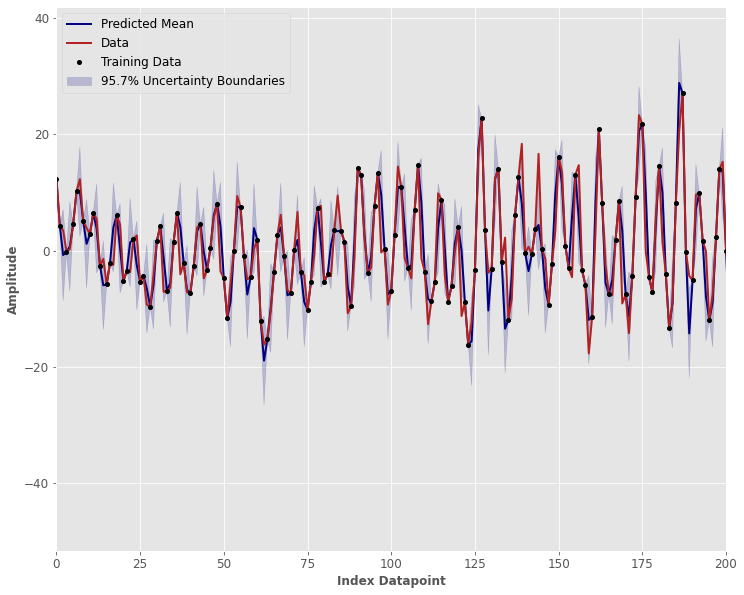

In [518]:
X = np.array(data.index.tolist()).reshape(-1,1)
y =np.array(data['detrend_data']).reshape(-1,1)
X=X.ravel()
plt.plot(X,pred_mean,color='navy',label='Predicted Mean')
plt.fill_between(X,pred_mean-1.96*pred_std,pred_mean+1.96*pred_std,color='navy',alpha=0.2,label='95.7% Uncertainty Boundaries')
plt.plot(X,y,color='firebrick',label='Data')
X = np.array(train_data.index.tolist()).reshape(-1,1)
y =np.array(train_data['detrend_data']).reshape(-1,1)
plt.plot(X,y,'.',label='Training Data',color='k')
plt.legend()
plt.xlabel('Index Datapoint')
plt.ylabel('Amplitude')
plt.xlim(0,200)

### Outliers

In [521]:
outliers = []
count_outliers = []
lower_bound, upper_bound = pred_mean-1.96*pred_std,pred_mean+1.96*pred_std
k=0
for i in range(len(data)):
    if (data['detrend_data'].loc[i]>upper_bound[i]) or (data['detrend_data'].loc[i]<lower_bound[i]):
        k=k+1
        outliers.append(1)
        count_outliers.append(k)
    else:
        outliers.append(0)
        count_outliers.append(k)


In [522]:
data['outlier'] = outliers
data['count_outlier'] = count_outliers

In [523]:
years_periods = np.arange(data.year.min(),data.year.max(),10).astype(int)

In [524]:
outliers_periods = []
for y in years_periods[:-1]:
    data_five = data[(data.year>y) & (data.year<y+5)]
    outliers_periods.append(data_five.outlier.sum())

/Users/pieropaialunga/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Number Of Outliers')

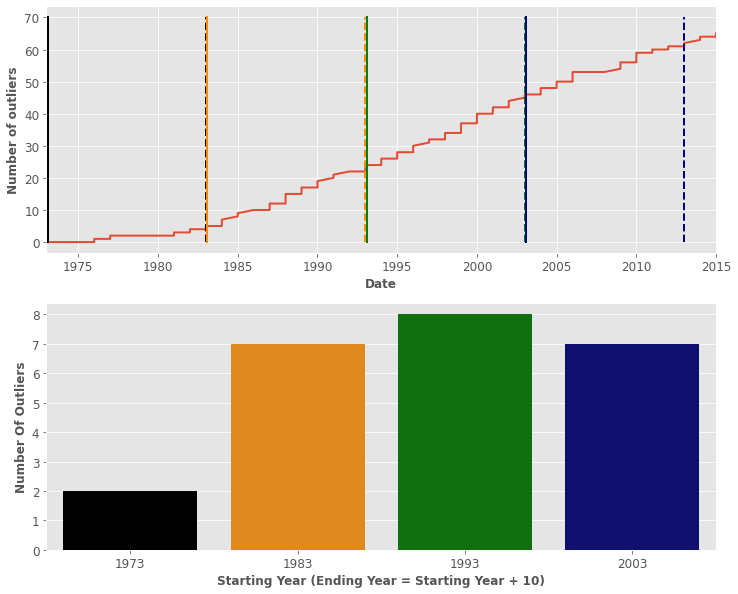

In [528]:
plt.subplot(2,1,1)
step=10
plt.plot(data.year,data.count_outlier)
plt.xlabel('Date')
plt.ylabel('Number of outliers')
colors = ['k','darkorange','green','navy']
i=0
for y in years_periods[:-1]:
    plt.plot(np.zeros(10)+y+0.1,np.linspace(0,70,10),color=colors[i])
    plt.plot(np.zeros(10)+y+step,np.linspace(0,70,10),color=colors[i],linestyle='--')
    i=i+1
plt.xlim(data.year.min(),2015)
plt.subplot(2,1,2)
data_count = pd.DataFrame([outliers_periods,years_periods[:-1]]).T
sns.barplot(data_count[1],data_count[0],palette=colors)
plt.xlabel('Starting Year (Ending Year = Starting Year + 10)')
plt.ylabel('Number Of Outliers')